# Student Name: Lucy Tan

# Preface

In this problem we consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" and "transplant". 

We assume that the Markov property holds. There are three additional states of the Markov Decision Process: "Pretransplant Death", "Posttransplant Life" and "Posttransplant Death" with no actions available. Assume that the length of episodes is T=50. "Pretransplant Death" and "Posttransplant Death" are absorbing states (time stops).

If patient selects "wait", the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Pretransplant Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Pretransplant Death  
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Pretransplant Death

If a patient selects "transplant" in Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there is the transition  
5) "Posttransplant Life"->"Posttransplant Death"  

Assume that   

P(Stage (k+1)|Stage k, "wait")=0.10 for k=1,2,...,17  
P(Stage (k-1)|Stage k, "wait")=0.02 for k=2,3,...,18  

P(Pretransplant Death|Stage k, "wait")=k*c for k=1,2,...,18 and some constant c.  

P(Stage k|Stage k, "wait")=0.9-kc for k=1   
P(Stage k|Stage k, "wait")=0.98-kc for k=18   
P(Stage k|Stage k, "wait")=0.88-kc for k=2,...,17   

Further, assume that   
P(Posttransplant Death|Posttransplant Life)= 4*c for the same constant c.


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


# Problem 1 (20 points)
Assume c = 0.01. Using the Monte Carlo control with $\varepsilon$-soft policy (without Exploring starts), estimate the policy for each State k, k=1,2,...,18. Use $\varepsilon$ = 0.05.

In [3]:
import collections
import numpy as np
import random

def admissible_actions(state):
    actions = list((0,1)) if state in admissible_stages() else None
    return actions

def admissible_stages():
    return list(range(1,19))

def additional_states():
    return ['pre_t_d', 'post_t_l', 'post_t_d']

def get_trans_probs(state, action, c):
    mapping = {}   # [new state, reward]
    pre_t_d = additional_states()[0]
    post_t_l = additional_states()[1]
    post_t_d = additional_states()[2]
    if state == post_t_l:
        mapping[(post_t_d, 0)] = 4 * c
        mapping[(state, 0.2)] = 1 - 4 * c
        return mapping
    if state == pre_t_d or state == post_t_d:
        mapping[(state, 0)] = 1
        return mapping
    
    stages = admissible_stages()
    wait = admissible_actions(state)[0]
    transplant = admissible_actions(state)[1]
    if action == wait and state in stages:
        mapping[(pre_t_d, 0)] = state * c
        if state in stages[0:17]:
            mapping[(state + 1, 1)] = 0.1
        if state in stages[1:18]:
            mapping[(state - 1, 1)] = 0.02
        if state == stages[0]:
            mapping[(state, 1)] = 0.9 - state * c
        if state in stages[1:17]:
            mapping[(state, 1)] = 0.88 - state * c
        if state == stages[17]:
            mapping[(state, 1)] = 0.98 - state * c
    if action == transplant and state in stages:
        mapping[(post_t_l, 0.2)] = 1
    return mapping
    
def get_policy(num_episodes, T, gamma, epsilon, c):
    pi = np.full((18, 2), fill_value=0.5)   # arbitrary epsilon-soft policy
    Q = np.zeros((18, 2), dtype=float)
    returns = collections.defaultdict(list)
    for episode_num in range(num_episodes):
        episode = generate_episode(pi, T, c, episode_num)
        states = episode[0]
        actions = episode[1]
        rewards = episode[2]
        G = 0
        for t in range(T-1, -1, -1):
            G = gamma * G + rewards[t+1]
            action = actions[t]
            if action is None or occurred_earlier(states, actions, t):
                continue
            state = states[t] - 1
            returns[(state, action)].append(G)
            Q[state, action] = np.mean(returns[(state, action)])
            greedy_action = np.random.choice(np.flatnonzero(Q[state] == Q[state].max()))
            allowed_actions = admissible_actions(state + 1)
            for a in allowed_actions:
                if a == greedy_action:
                    pi[state, a] = 1 - epsilon + epsilon / len(allowed_actions)
                else:
                    pi[state, a] = epsilon / len(allowed_actions)
    return pi
                
def generate_episode(pi, T, c, episode_num):
    episode = collections.defaultdict(list)
    state = episode_num % 18 + 1
    episode[2].append(None)   # to fill in R0
    for t in range(T):
        episode[0].append(state)
        action = get_action(pi, state)
        episode[1].append(action)
        new_state, reward = get_next(state, action, c)
        episode[2].append(reward)
        state = new_state
    return episode

def get_action(pi, state):
    rand = random.random()
    if state not in admissible_stages():
        return None
    return 0 if rand < pi[state - 1][0] else 1

def get_next(state, action, c):
    mapping = get_trans_probs(state, action, c)
    transitions = []
    probs = []
    for trans, prob in mapping.items():
        transitions.append(trans)
        probs.append(prob)
    index = np.random.choice(len(transitions), p=probs)
    new_state, reward = transitions[index]
    return new_state, reward
    
def occurred_earlier(states, actions, cur_timestep):
    for earlier_timestep in range(cur_timestep):
        if states[cur_timestep] == states[earlier_timestep] and actions[cur_timestep] == actions[earlier_timestep]:
            return True
    return False

c = 0.01
epsilon = 0.05
gamma = 0.97
T = 50
num_episodes = 10000

print('Epsilon-soft policy gives [probability of wait, probability of transplant] for each of 18 states:')
print(get_policy(num_episodes, T, gamma, epsilon, c))

Epsilon-soft policy gives [probability of wait, probability of transplant] for each of 18 states:
[[0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]
 [0.975 0.025]]


# Problem 2 (5 points)
Run the algorithm you developed in Problem 1 for c =0.001,0.002,0.003,...,0.040. For each c, identify the minimal k such that the agent will select "transplant" (i.e. minimal k such that policy $\pi$(trsansplant|Stage k) > 0.5) in State k. Plot this k versus c. Discuss the result.

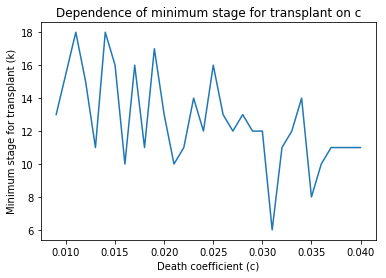

In [4]:
import matplotlib.pyplot as plt
cs = []
ks = []
for i in range(1, 41):
    c = i * 0.001
    pi = get_policy(num_episodes, T, gamma, epsilon, c)
    try:
        k = np.min(np.flatnonzero(0.5 < pi[:,1])) + 1
    except ValueError:
        continue
    cs.append(c)
    ks.append(k)
plt.plot(cs, ks)
plt.title('Dependence of minimum stage for transplant on c')
plt.ylabel('Minimum stage for transplant (k)')
plt.xlabel('Death coefficient (c)')
plt.show()

As c increases, there is a downward trend for minimum stage of transplant (k).

Explanation:  
Increasing c directly increases the transition probability for pretransplant death. 
Furthermore, later stages get a greater increase in probability of pretransplant death than earlier stages. For example, the transition probability of getting pretransplant death when the stage is 17 is 17c, compared to 2c when the stage is 2. When c=0.01, 17c=0.17 and 2c=0.02. When c=0.04, 17c=0.68 and 2c=0.08. This shows that the transition probability of getting pretransplant death at stage 17 increased by 0.51, whereas getting pretransplant death at stage 2 only increased by 0.06. Choosing to wait is less appealing, given the increased probability of getting pretransplant death. As a result, as c increases, it is better to choose transplant while at an earlier stage. 

Note: while c also directly increases the transition probability for posttransplant death, it is at a much lower rate overall (4c) than the increase in pretransplant death (for most states).

Why the minimum stage of transplant is not monotonically decreasing:  
This may be due to the policy not converging to an optimal epsilon-soft policy. In the problem, the epsilon-soft policy has a 0.95 probability of choosing the greedy action and 0.05 of choosing randomly. In the 0.05 probability of choosing randomly, the greedy action is chosen half of the time (since there are always two actions). Therefore, there is only 0.025 probability of choosing the non-greedy action that could potentially be a better action than the greedy one.
As a result, the number of episodes would need to be very large for the policy to converge to an optimal epsilon-soft policy and for the graph to show a monotonically decreasing function.